In [1]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
import pickle
import os

In [2]:
# Constants
N = 10000   # Number of data points
K = 10      # Number of classes
D = 3072    # Number of dimensions

In [3]:
class Data():
    def __init__(self, filename=None):

        self.data = None
        self.hot = None
        self.labels = None

        if filename:
            self.setDataFromFile(filename)
            self.transform()

        # Precompute flipped indices
        indices = np.array(range(D))
        imageidx = indices.reshape(32, 32, 3, order="F")
        flipped_imageidx = np.flip(imageidx, axis=0)
        self.flipped_idx = flipped_imageidx.reshape(D, order="F")

    def loadData(self, filename):
        """ Copied from the dataset website """
        import pickle
        with open('./Datasets/cifar-10-batches-py/'+filename, 'rb') as fo:
            batch = pickle.load(fo, encoding='bytes')
        
        labels = np.array(batch[b"labels"])

        dict = {
         "labels": labels,
         "data": batch[b"data"].T.astype(float),
         "hot": self.onehotencoding(labels)
         }

        return dict

    def onehotencoding(self, labels):
        """
        One-hot encodes the given labels.
        
        Args:
            labels (np.array): The labels to be one-hot encoded.
            
        Returns:
            np.array: The one-hot encoded labels.
        """
        N = len(labels)
        hot = np.zeros((K, N))
        for i in range(N):
            hot[labels[i]][i] = 1
        return hot

    def setDataFromFile(self, fname):
        """
        Sets the data to the contents at the file filename.        
        """
        batch = self.loadData(fname)
        self.labels = batch["labels"]
        self.data = batch["data"]
        self.hot = batch["hot"]
    
    def concatData(self, fname):
        """
        Concatenates the data from the given filename to the existing data.
        
        Args:
            fname (str): The path to the file containing the data.
        """
        
        batch = self.loadData(fname)
        
        if self.labels is not None:
            self.labels = np.concatenate((self.labels, batch["labels"]))
        else:
            self.labels = batch["labels"]
        
        if self.data is not None:
            self.data = np.concatenate((self.data, batch["data"]), axis=1)
        else:
            self.data = batch["data"]

        self.hot = self.onehotencoding(self.labels)

    def transform(self):
        """
        Transforms the given dataset by normalizing the data.
        """
        meanX = np.mean(self.data, axis=0)
        stdX = np.std(self.data, axis=0)
        self.data = (self.data - meanX) / stdX
    
    def shuffle(self):
        """
        Shuffles the data.
        """
        permutation = np.random.permutation(self.data.shape[1])
        self.data = self.data[:, permutation]
        self.hot = self.hot[:, permutation]
        self.labels = self.labels[permutation]
    
    def miniBatch(self, batch, range):
        """
        Creates a mini-batch of the given batch.
        """
        self.data = batch.data[:, range[0]:range[1]]
        self.hot = batch.hot[:, range[0]:range[1]]
        self.labels = batch.labels[range[0]:range[1]]
    
    def flip(self, pflip):
        """
        Flips the data with a given probability.
        
        Args:
            pflip (float): The probability of flipping the data.
        """
        flip = np.random.rand(self.data.shape[1]) < pflip
        self.data[:,flip] = self.data[:,flip][self.flipped_idx]

# Model

In [4]:
class LinearKLayer:
    def __init__(self, k, d, m, seed = None, batchnorm = False, sigma=None):
        """
        Initializes the weights and biases of the 2 layers.
        """
        if seed:
            np.random.seed(seed)

        weightDims = [d] + m + [k]
        inDims = weightDims[:-1]
        outDims = weightDims[1:]
        
        self.layers = []

        for dIn, dOut in zip(inDims, outDims):
            # Initiliazation mode
            if sigma:
                W = np.random.normal(0, sigma, size=(dOut, dIn))
                gamma = np.random.normal(1, sigma, size = (dOut, 1))
            else:
                # He initialization
                W = np.random.normal(0, 1/np.sqrt(dIn), size=(dOut, dIn))
                gamma = np.random.normal(1, 1/np.sqrt(dOut), size = (dOut, 1))

            self.layers.append({
                "W": W,
                "b": np.zeros((dOut, 1)),
                "gradW": None,
                "gradB": None,
                "S": None,
                "S_hat": None,
                "H": None,
                #"mu": np.zeros((dOut, 1)),
                "mu": None,
                "beta": np.zeros((dOut, 1)),
                #"v": np.random.normal(1, 1/np.sqrt(dOut), size = (dOut, 1)),
                "v": None,
                "gamma": gamma,
                "gradBeta": None,
                "gradGamma": None
            })

        self.batchnorm = batchnorm
        self.p = None
        self.k = K
        self.d = d

    
    # Activation functions #
    def softmax(self, x):
        """ Standard definition of the softmax function """
        return np.exp(x) / np.sum(np.exp(x), axis=0)

    def sigmoid(self, x):
        """ Standard definition of the sigmoid function """
        return 1 / (1 + np.exp(-x))
    
    def relu(self, x):
        """ Standard definition of the ReLU function """
        return np.maximum(0, x)
    
    ########################################
    def updateBatchNormParams(self, muList, vList):
        for mu, v, layer in zip(muList, vList, self.layers[:-1]):
            layer["mu"] = mu
            layer["v"] = v

    def forward(self, batch, train=False, alpha=0.8):
        """
        Evaluate the classifier for a given input.

        Args:
            data (dict): A dictionary containing the data and one-hot encoded labels.
        """
        self.layers[0]["H"] = batch.data.copy()

        for i, layer in enumerate(self.layers[:-1]):
            s = layer["W"] @ layer["H"] + layer["b"]
            layer["S"] = s.copy()

            if self.batchnorm:
                if train:
                    mu = np.mean(s, axis=1).reshape(-1, 1)
                    v = np.var(s, axis=1).reshape(-1, 1)

                    if layer["mu"] is None:
                        layer["mu"] = mu
                        layer["v"] = v

                    layer["mu"] = alpha*layer["mu"]+(1-alpha)*mu
                    layer["v"] = alpha*layer["v"]+(1-alpha)*v
                else:
                    mu = layer["mu"]
                    v = layer["v"]

                s = (s - mu) / np.sqrt(v + 1e-8)
                layer["S_hat"] = s.copy()

                s = layer["gamma"] * s + layer["beta"] # s-tilde

            self.layers[i + 1]["H"] = self.relu(s)

        s = self.layers[-1]["W"] @ self.layers[i + 1]["H"] + self.layers[-1]["b"]
        self.p = self.softmax(s)
        
    
    def lcross(self, batch):
        """
        Calculates the cross-entropy loss.

        Args:
            data (dict): A dictionary containing the data and one-hot encoded labels.

        Returns:
            float: Cross-entropy loss.
        """
        Y = batch.hot
        return - Y * np.log(self.p)
    
    def lmultiplebce(self, batch):
        """
        Calculates the K-binary cross-entropy loss.

        Args:
            data (dict): A dictionary containing the data and one-hot encoded labels.

        Returns:
            float: Binary cross-entropy loss.
        """
        Y = batch.hot
        return -Y * np.log(self.p) - (1 - Y) * np.log(1 - self.p)
    
    def computeCost(self, batch, lmda, loss = "lcross"):
        """
        Compute the cost function for linear regression with regularization.

        Args:
            data (dict): A dictionary containing the data and one-hot encoded labels.
            lmda (float): Regularization parameter.

        Returns:
        float: The computed cost.
        """
        X = batch.data

        if loss == "lcross":
            loss_cross = self.lcross(batch)
            denom = X.shape[1]
        else:
            loss_cross = self.lmultiplebce(batch)
            denom = K
        
        loss_term = 1 / denom * np.sum(loss_cross)
        
        # Regularization term
        reg_term = 0

        for layer in self.layers:
            reg_term += np.sum(layer["W"] ** 2)

        reg_term *= lmda

        return loss_term + reg_term, loss_term
    
    def computeAcc(self, batch):
        """
        Compute the accuracy of the classifier.

        Args:
            data (dict): A dictionary containing the data and one-hot encoded labels.

        Returns:
            float: Accuracy of the classifier.

        """
        Y = batch.hot
        pred = np.argmax(self.p, axis=0)
        return np.mean(pred == np.argmax(Y, axis=0))
    

    def batchNormBackPass(self, G, layer):
        eps = 1e-8
        n = G.shape[1]
        onevec = np.ones((1, n))
        sig1 = np.power(layer["v"] + eps, -0.5)
        sig2 = np.power(layer["v"] + eps, -1.5)
        G1 = G * (sig1 @ onevec)
        G2 = G * (sig2 @ onevec)
        D = layer["S"] - (layer["mu"] @ onevec)
        c = (G2 * D) @ onevec.T
        return G1 - (G1 @ onevec.T) @ onevec / n - D * (c @ onevec) / n

    def backward(self, batch, lmda):
        """
        Compute the gradients of the cost function with respect to the parameters.

        Args:
            data (dict): A dictionary containing the data and one-hot encoded labels.
            lmbd (float): Regularization parameter.

        Returns:
            list: A list containing the gradients of the cost function with respect to the weight matrix W and the bias vector b.
        """
        X, Y = batch.data, batch.hot
        nBatch = X.shape[1]
    
        G = (self.p - Y)

        # FIXME: Index here might be wrong (of h)
        self.layers[-1]["gradW"] = 1 / nBatch * G @ self.layers[-1]["H"].T + 2 * lmda * self.layers[-1]["W"]
        self.layers[-1]["gradB"] = 1 / nBatch * np.sum(G, axis = 1).reshape(-1, 1)
        
        G = self.layers[-1]["W"].T @ G
        G = G * (self.layers[-1]["H"] > 0)
        
        for l, layer in reversed(list(enumerate(self.layers[:-1]))):

            if self.batchnorm:
                layer["gradGamma"] = 1 / nBatch * np.sum(G * layer["S_hat"], axis=1).reshape(-1, 1)
                layer["gradBeta"] = 1 / nBatch * np.sum(G, axis=1).reshape(-1, 1)
                G = G * (layer["gamma"] @ np.ones((1, nBatch)))
                G = self.batchNormBackPass(G, layer)

            # FIXME: Index here might be wrong (of h)
            layer["gradW"] = 1 / nBatch * G @ layer["H"].T + 2 * lmda * layer["W"]
            layer["gradB"] = 1 / nBatch * np.sum(G, axis = 1).reshape(-1, 1)

            G = layer["W"].T @ G
            G = G * (layer["H"] > 0)
                

    def GradCenteredDifference(self, batch, lmda, h = 1e-6):
        """
        Compute the gradients of the cost function with respect to the parameters using centered difference.

        Args:
            data (dict): A dictionary containing the data and one-hot encoded labels.
            lmbd (float): Regularization parameter.
            h (float): The step size for the centered difference.

        Returns:
            list: A list containing the gradients of the cost function with respect to the weight matrix W and the bias vector b.
        """

        grads = [{"gradW": None, "gradB": None, "gradBeta": None, "gradGamma": None} for _ in self.layers]

        for k, layer in enumerate(self.layers):
            # Initialize gradients
            grads[k]["gradW"] = np.zeros(layer["W"].shape)
            grads[k]["gradB"] = np.zeros(layer["b"].shape)
            grads[k]["gradBeta"] = np.zeros(layer["beta"].shape)
            grads[k]["gradGamma"] = np.zeros(layer["gamma"].shape)

            # Calculate numerically
            for i in range(layer["W"].shape[0]):
                for j in range(layer["W"].shape[1]):
                    layer["W"][i,j] += h
                    self.forward(batch)
                    cost1, _ = self.computeCost(batch, lmda)
                    layer["W"][i,j] -= 2 * h
                    self.forward(batch)
                    cost2, _ = self.computeCost(batch, lmda)
                    grads[k]["gradW"][i, j] = (cost1 - cost2) / (2 * h)
                    layer["W"][i,j] += h

            for i in range(layer["b"].shape[0]):
                layer["b"][i] += h
                self.forward(batch)
                cost1, _ = self.computeCost(batch, lmda)
                layer["b"][i] -= 2 * h
                self.forward(batch)
                cost2, _ = self.computeCost(batch, lmda)
                grads[k]["gradB"][i] = (cost1 - cost2) / (2 * h)
                layer["b"][i] += h
            
            for i in range(layer["beta"].shape[0]):
                layer["beta"][i] += h
                self.forward(batch)
                cost1, _ = self.computeCost(batch, lmda)
                layer["beta"][i] -= 2 * h
                self.forward(batch)
                cost2, _ = self.computeCost(batch, lmda)
                grads[k]["gradBeta"][i] = (cost1 - cost2) / (2 * h)
                layer["beta"][i] += h

            for i in range(layer["gamma"].shape[0]):
                layer["gamma"][i] += h
                self.forward(batch)
                cost1, _ = self.computeCost(batch, lmda)
                layer["gamma"][i] -= 2 * h
                self.forward(batch)
                cost2, _ = self.computeCost(batch, lmda)
                grads[k]["gradGamma"][i] = (cost1 - cost2) / (2 * h)
                layer["gamma"][i] += h

        return grads

    def update(self, eta):
            """
            Update the parameters of the model.
            """
            for layer in self.layers:
                layer["W"] -= eta * layer["gradW"]
                layer["b"] -= eta * layer["gradB"]


In [5]:
class Visualizer:
    def plotResults(self, title, costs, loss, accs, test_acc = None):
        """
        Plot the results of the training.
        """
        plt.figure(figsize=(16, 6))
        plt.suptitle(title)

        plt.subplot(1, 3, 1)
        plt.plot(costs["train"], label="Training")
        plt.plot(costs["val"], label="Validation")
        plt.xlabel("Epoch")
        plt.ylabel("Cost")
        plt.legend()

        plt.subplot(1, 3, 2)
        plt.plot(loss["train"], label="Training")
        plt.plot(loss["val"], label="Validation")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()

        plt.subplot(1, 3, 3)
        plt.plot(accs["train"], label="Training")
        plt.plot(accs["val"], label="Validation")
        if test_acc:
            plt.axhline(test_acc, color="red", label="Test Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()

        plt.tight_layout()    
        plt.show()

    def genWeightImage(self, slice):
        """
        Generates an image from the given slice of the weight matrix.
        
        Args:
            slice (numpy.ndarray): The slice of the weight matrix.
            
        Returns:
            numpy.ndarray: The generated image.
        """
        
        img = slice.reshape(32, 32, 3, order="F")
        img = img - np.min(img)
        img = img / np.max(img)
        return img

    def genMatrixVisualization(self, title, W):
        plt.figure(figsize=(12, 6))

        for i in range(K):
            plt.subplot(2, 5, i+1)
            plt.imshow(self.genWeightImage(W[i, :]))
            plt.title(f"Slice {i}")

        plt.tight_layout()
        plt.suptitle(title)
        plt.show()

    def plotLearningRate(self, title, lrs, lr_max, lr_min, stepsize):
        plt.figure(figsize=(12, 6))
        plt.plot(lrs)
        plt.axhline(lr_max, color="red", label="Max Learning Rate")
        plt.axhline(lr_min, color="green", label="Min Learning Rate")
        plt.xticks(range(0, len(lrs), stepsize))
        plt.xlabel("Epoch")
        plt.ylabel("Learning Rate")
        plt.title(title)
        plt.legend()
        plt.show()
    
    def plotCyclicResults(self, title, costs, loss, accs, stepsize, test_acc = None):
        """
        Plot the results of the training.
        """
        plt.figure(figsize=(16, 6))
        plt.suptitle(title)

        X = [i*stepsize//10 for i in range(len(costs["train"]))]

        plt.subplot(1, 3, 1)
        plt.plot(X,costs["train"], label="Training")
        plt.plot(X,costs["val"], label="Validation")
        plt.ylim(0, 1.2 * max(costs["train"]))
        plt.xlabel("Step")
        plt.ylabel("Cost")
        plt.legend()

        plt.subplot(1, 3, 2)
        plt.plot(X,loss["train"], label="Training")
        plt.plot(X,loss["val"], label="Validation")
        plt.ylim(0, 1.2 * max(loss["train"]))
        plt.xlabel("Step")
        plt.ylabel("Loss")
        plt.legend()

        plt.subplot(1, 3, 3)
        plt.plot(X,accs["train"], label="Training")
        plt.plot(X,accs["val"], label="Validation")
        if test_acc:
            plt.axhline(test_acc, color="red", label="Test Accuracy")
        plt.ylim(0, 1.2 * max(accs["train"]))
        plt.xlabel("Step")
        plt.ylabel("Accuracy")
        plt.legend()

        plt.tight_layout()    
        plt.show()

    def plotBnResults(self, title, paramsO, paramsBN, stepsize, test_acc = None):
        """
        Plot the results of the training.
        """

        costs, loss, accs = paramsO
        costsBN, lossBN, accsBN = paramsBN

        plt.figure(figsize=(16, 6))
        plt.suptitle(title)

        X = [i*stepsize//10 for i in range(len(costs["train"]))]

        plt.subplot(1, 3, 1)
        plt.plot(X,costs["train"], label="Training")
        plt.plot(X,costs["val"], label="Validation")
        # batchnorm plot dashed
        plt.plot(X,costsBN["train"], label="Training BN", linestyle='dashed')
        plt.plot(X,costsBN["val"], label="Validation BN", linestyle='dashed')
        plt.ylim(0, 1.2 * max(max(costs["train"]), max(costsBN["train"])))
        plt.xlabel("Step")
        plt.ylabel("Cost")
        plt.legend()

        plt.subplot(1, 3, 2)
        plt.plot(X,loss["train"], label="Training")
        plt.plot(X,loss["val"], label="Validation")
        # batchnorm plot dashed
        plt.plot(X,lossBN["train"], label="Training BN", linestyle='dashed')
        plt.plot(X,lossBN["val"], label="Validation BN", linestyle='dashed')
        plt.ylim(0, 1.2 * max(max(loss["train"]), max(lossBN["train"])))
        plt.xlabel("Step")
        plt.ylabel("Loss")
        plt.legend()

        plt.subplot(1, 3, 3)
        plt.plot(X,accs["train"], label="Training")
        plt.plot(X,accs["val"], label="Validation")
        # batchnorm plot dashed
        plt.plot(X,accsBN["train"], label="Training BN", linestyle='dashed')
        plt.plot(X,accsBN["val"], label="Validation BN", linestyle='dashed')
        if test_acc:
            plt.axhline(test_acc, color="red", label="Test Accuracy")
        plt.ylim(0, 1.2 * max(max(accs["train"]), max(accsBN["train"])))
        plt.xlabel("Step")
        plt.ylabel("Accuracy")
        plt.legend()

        plt.tight_layout()    
        plt.show()

In [6]:
def cyclicLearningRate(eta_min, eta_max, stepsize, t):
    """
    Compute the learning rate for the given stepsize and t.
    
    Args:
        eta_min (float): The minimum learning rate.
        eta_max (float): The maximum learning rate.
        stepsize (int): The stepsize.
        t (int): The current iteration.
        
    Returns:
        float: The learning rate.
    """
    l = t // (2 * stepsize)
    if 2*l*stepsize <= t <= (2*l+1)*stepsize:
        return eta_min + (t - 2*l*stepsize) / stepsize * (eta_max - eta_min)
    else:
        return eta_max - (t - (2*l+1)*stepsize) / stepsize * (eta_max - eta_min)

In [7]:
def miniBatchGD(train, model, lmbd=0.1, n_batch=100, scheduler=["static",[0.001]], n_epochs=20, val=None, pflip=0, seed=65465168, n_cycles=2):
        """
        Perform mini-batch gradient descent.

        Args:
            X (numpy.ndarray): Input data of shape (d, N).
            Y (numpy.ndarray): One-hot encoded true label of shape (K, N).
            W (numpy.ndarray): Weight matrix of shape (K, d).
            b (numpy.ndarray): Bias vector of shape (K, 1).
            lmbd (float, optional): Regularization parameter. Defaults to 0.1.
            n_batch (int, optional): Number of mini-batches. Defaults to 100.
            scheduler (list, optional): Learning rate scheduler. Defaults to static eta = 0.001.
            n_epochs (int, optional): Number of epochs. Defaults to 20.

        Returns:
            tuple: A tuple containing the weight matrix W and the bias vector b.
        """
        np.random.seed(seed)
        
        costs = {"train" : [], "val" : []}
        loss = {"train" : [], "val" : []}
        accs = {"train" : [], "val" : []}
        lr = []

        if scheduler[0] == "static":
            eta = scheduler[1][0]
        elif scheduler[0] == "cyclic":
            eta_min, eta_max, n_s = scheduler[1]
            eta = eta_min
            t = 0
        else:
            raise ValueError("Invalid scheduler")
        
        for epoch in range(n_epochs):
            # Shuffle data
            train.shuffle()

            n_mini_batches = int(train.data.shape[1] / n_batch)
            for j in range(n_mini_batches):
                # Assemble mini-batch
                batch = Data()
                j_start = j * n_batch
                j_end = (j + 1) * n_batch
                batch.miniBatch(train, [j_start, j_end])
                if pflip > 0:
                    batch.flip(pflip)

                if scheduler[0] == "cyclic":
                    eta = cyclicLearningRate(eta_min, eta_max, n_s, t)
                    t += 1

                model.forward(batch, train=True)
                model.backward(batch, lmbd)
                model.update(eta)

                lr.append(eta)

                if scheduler[0] == "cyclic" and t % (n_s / 10) == 0:
                    model.forward(train)
                    c, l = model.computeCost(train, lmbd)
                    costs["train"].append(c)
                    loss["train"].append(l)
                    accs["train"].append(model.computeAcc(train))
                    if val:
                        model.forward(val)
                        c, l = model.computeCost(val, lmbd)
                        costs["val"].append(c)
                        loss["val"].append(l)
                        accs["val"].append(model.computeAcc(val))
                
            if scheduler[0] == "static":
                model.forward(train)
                c, l = model.computeCost(train, lmbd)
                costs["train"].append(c)
                loss["train"].append(l)
                accs["train"].append(model.computeAcc(train))
                if val:
                    model.forward(val)
                    c, l = model.computeCost(val, lmbd)
                    costs["val"].append(c)
                    loss["val"].append(l)
                    accs["val"].append(model.computeAcc(val))


        return model, costs, loss, accs, lr

# Build Parameters

Restructure for each layer to contain backward pass update depending on activation funcion for modularity.
See p. 36 in slides

In [8]:
# Load All Data

# Combine all training batches
alltrain = Data()
for _ in range(5):
    alltrain.concatData(f"data_batch_{_+1}")
alltrain.transform()

val = Data()
val.miniBatch(alltrain, [0, 5000])

train = Data()
train.miniBatch(alltrain, [5000,alltrain.data.shape[1]])

del alltrain

# Partition test batch into validation and test sets
test = Data("test_batch")

In [9]:
subset = Data()
subset.miniBatch(train,[0,5])

In [10]:
def relerr(ga, gn, eps=1e-6):
        """
        Calculates the relative error between two vectors.

        Args:
            ga (numpy.ndarray): Analytical gradient.
            gn (numpy.ndarray): Numerical gradient.
            eps (float, optional): A small value to avoid division by zero. Defaults to 1e-6.

        Returns:
            float: The relative error between ga and gn.
        """
        
        diff = np.linalg.norm(ga - gn)
        norma = np.linalg.norm(ga)
        normn = np.linalg.norm(gn)
        numer = max(eps, norma + normn)
        return diff / numer

# Sanity check with numerical gradients

In [11]:
lmda = 0.1
model = LinearKLayer(K, D, [30, 20, 15], seed=65465168)
grads = model.GradCenteredDifference(subset, lmda, h=1e-5)
model.forward(subset, train=True)
model.backward(subset, lmda)

for i, layer in enumerate(model.layers):
    numGradW = grads[i]["gradW"]
    numGradB = grads[i]["gradB"]

    print(f"Layer {i+1}")
    print("Relative error W:", relerr(numGradW, layer["gradW"]))
    print("Relative error B:", relerr(numGradB, layer["gradB"]))

Layer 1
Relative error W: 1.0358548260629345e-09
Relative error B: 5.237308148806803e-10
Layer 2
Relative error W: 5.142529832496727e-10
Relative error B: 5.606267813624724e-10
Layer 3
Relative error W: 4.112411627551934e-10
Relative error B: 2.332804449188737e-10
Layer 4
Relative error W: 4.171976204008959e-10
Relative error B: 1.5788464303118856e-10


# Sanity check with numerical gradients BATCHNORM

## 2 layer

In [12]:
lmda = 0.01
model = LinearKLayer(K, D, [50], seed=65465168, batchnorm=True)

model.forward(subset, train=True)
model.backward(subset, lmda)

grads = model.GradCenteredDifference(subset, lmda, h=1e-5)

# Remember that batchnorm zeroes out the bias for all but the last layer

for i, layer in enumerate(model.layers):
    numGradW = grads[i]["gradW"]
    numGradB = grads[i]["gradB"]
    numGradBeta = grads[i]["gradBeta"]
    numGradGamma = grads[i]["gradGamma"]

    print(f"Layer {i}")
    print("Relative error W:", relerr(numGradW, layer["gradW"]))
    print("Relative error B:", relerr(numGradB, layer["gradB"]))
    if i < len(model.layers) - 1:
        print("Relative error Beta:", relerr(numGradBeta, layer["gradBeta"]))
        print("Relative error Gamma:", relerr(numGradGamma, layer["gradGamma"]))

Layer 0
Relative error W: 0.323028949707297
Relative error B: 0.9999999999999999
Relative error Beta: 1.9785483371249715e-10
Relative error Gamma: 1.9329936690171603e-10
Layer 1
Relative error W: 9.982824979738105e-11
Relative error B: 9.023101668750853e-11


## 3 layer

In [13]:
lmda = 0.01
model = LinearKLayer(K, D, [50, 50], seed=65465168, batchnorm=True)

model.forward(subset, train=True)
model.backward(subset, lmda)

grads = model.GradCenteredDifference(subset, lmda, h=1e-5)

# Remember that batchnorm zeroes out the bias for all but the last layer

for i, layer in enumerate(model.layers):
    numGradW = grads[i]["gradW"]
    numGradB = grads[i]["gradB"]
    numGradBeta = grads[i]["gradBeta"]
    numGradGamma = grads[i]["gradGamma"]

    print(f"Layer {i}")
    print("Relative error W:", relerr(numGradW, layer["gradW"]))
    print("Relative error B:", relerr(numGradB, layer["gradB"]))
    if i < len(model.layers) - 1:
        print("Relative error Beta:", relerr(numGradBeta, layer["gradBeta"]))
        print("Relative error Gamma:", relerr(numGradGamma, layer["gradGamma"]))

Layer 0
Relative error W: 0.4118654792969678
Relative error B: 0.9999999999999999
Relative error Beta: 0.5566506689491917
Relative error Gamma: 0.44879622257047397
Layer 1
Relative error W: 0.4124009747260574
Relative error B: 0.9999999999999999
Relative error Beta: 3.171340371107486e-10
Relative error Gamma: 4.02969076432145e-10
Layer 2
Relative error W: 9.740162243594635e-11
Relative error B: 1.0844779614311728e-10


# Cyclical Learning Rate Replication

In [14]:
# Load All Data

# Combine all training batches
alltrain = Data()
for _ in range(5):
    alltrain.concatData(f"data_batch_{_+1}")
alltrain.transform()

val = Data()
val.miniBatch(alltrain, [0, 5000])

train = Data()
train.miniBatch(alltrain, [5000,alltrain.data.shape[1]])

del alltrain

# Partition test batch into validation and test sets
test = Data("test_batch")

In [15]:
vis = Visualizer()

eta_min, eta_max = 1e-5, 1e-1
lmbd, n_batch = 0.01, 100
stepsize = int(5 * 45000 / n_batch)

lr_scheduler = ["cyclic",[eta_min, eta_max, stepsize]]



epoch_updates = train.data.shape[1]/n_batch
cycle_updates = 2 * stepsize
n_epochs_cycle = cycle_updates/epoch_updates

# 2 cycles worth of epochs
n_epochs = int(n_epochs_cycle * 2)

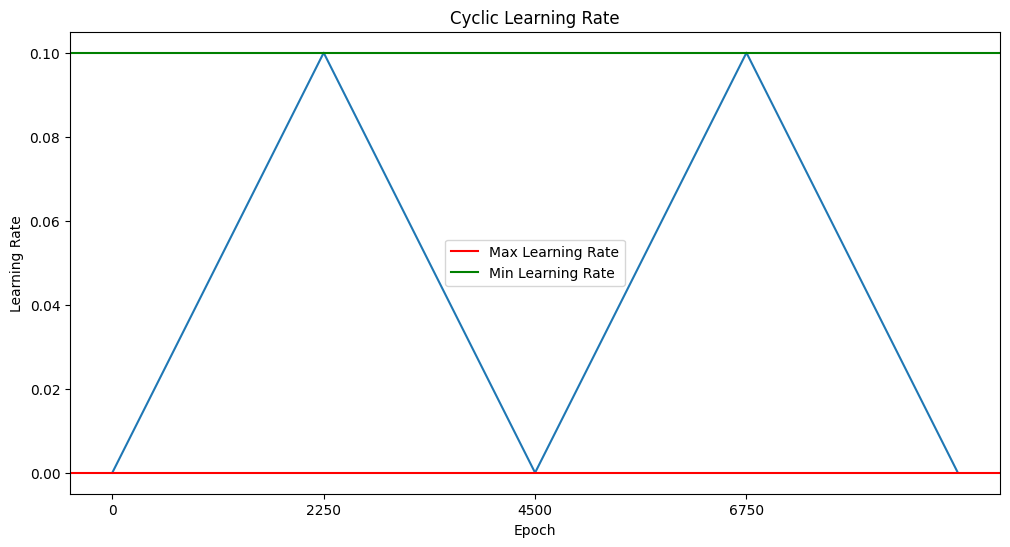

In [17]:
vis.plotLearningRate("Cyclic Learning Rate", lr, eta_min, eta_max, stepsize)

In [29]:
modelBN = LinearKLayer(K, D, [50], seed=65465168, batchnorm=True)
modeloutBN, costsBN, lossBN, accsBN, lr = miniBatchGD(train, modelBN, lmbd=0.01, n_batch=n_batch, scheduler=lr_scheduler, n_epochs=n_epochs, val=val, pflip=0)

In [ ]:
model0 = LinearKLayer(K, D, [50], seed=65465168, batchnorm=False)
modelout0, costs0, loss0, accs0, lr = miniBatchGD(train, model0, lmbd=0.01, n_batch=n_batch, scheduler=lr_scheduler, n_epochs=n_epochs, val=val, pflip=0)

In [ ]:
vis.plotBnResults("Batch Normalization vs. No Batch Normalization 2 Layer", [costs0, loss0, accs0], [costsBN, lossBN, accsBN], stepsize)

In [22]:
modeloutBN.forward(test)
print("Test accuracy BN: ", modeloutBN.computeAcc(test))
modelout0.forward(test)
print("Test accuracy: ", modelout0.computeAcc(test))

Test accuracy:  0.5111


# 3-Layer training

In [23]:
eta_min, eta_max = 1e-5, 1e-1
lmbd, n_batch = 0.005, 100
stepsize = int(5*45000/n_batch)

lr_scheduler = ["cyclic",[eta_min, eta_max, stepsize]]

epoch_updates = train.data.shape[1]/n_batch
cycle_updates = 2 * stepsize
n_epochs_cycle = cycle_updates/epoch_updates

# 2 cycles worth of epochs
n_epochs = int(n_epochs_cycle * 2)

In [24]:
model = LinearKLayer(K, D, [50, 50], seed=65465168, batchnorm=False)
modelout, costs, loss, accs, lr = miniBatchGD(train, model, lmbd=lmbd, n_batch=n_batch, scheduler=lr_scheduler, n_epochs=n_epochs, val=val, pflip=0)

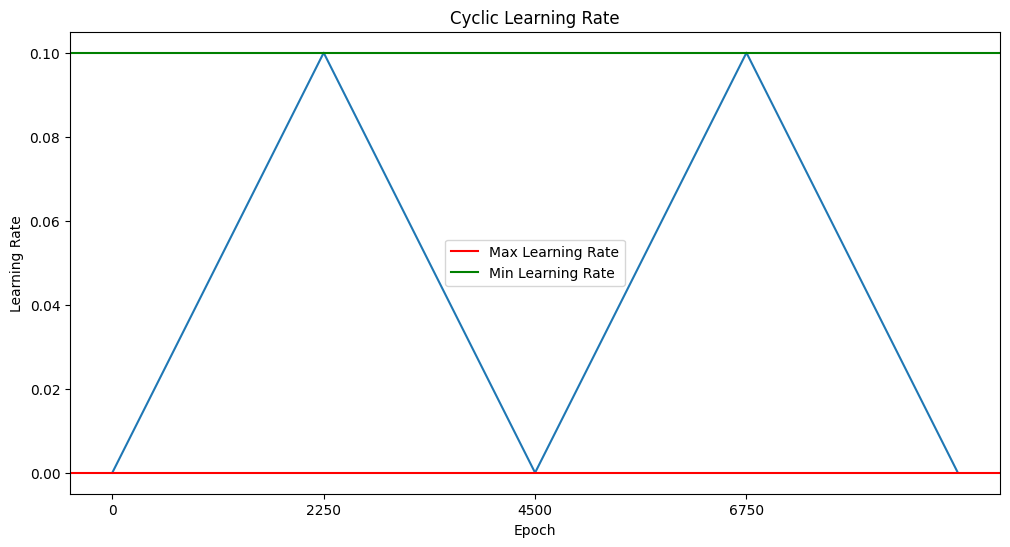

In [25]:
vis.plotLearningRate("Cyclic Learning Rate", lr, eta_min, eta_max, stepsize)

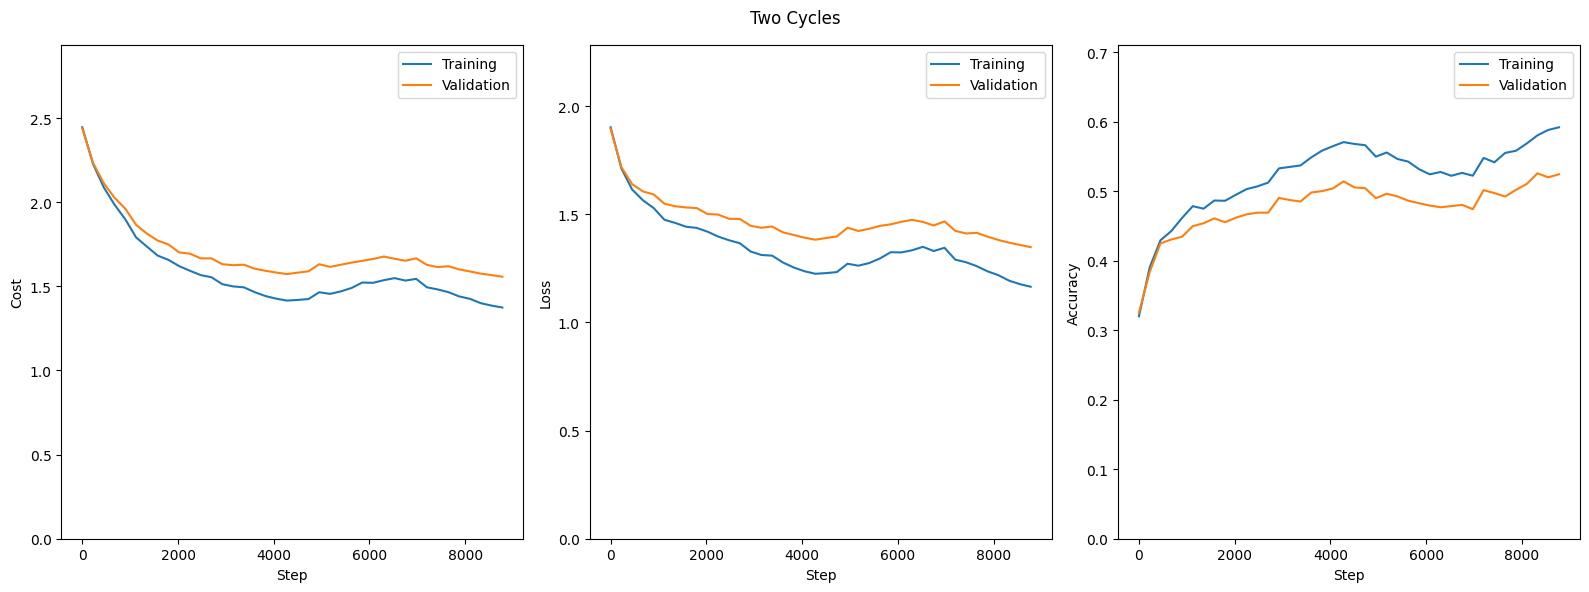

In [26]:
vis.plotCyclicResults("Two Cycles", costs, loss, accs, stepsize)

In [27]:
modelout.forward(test)
print("Test accuracy: ", modelout.computeAcc(test))

Test accuracy:  0.5152


In [28]:
model = LinearKLayer(K, D, [50, 50], seed=65465168, batchnorm=True)
modelout, costs, loss, accs, lr = miniBatchGD(train, model, lmbd=lmbd, n_batch=n_batch, scheduler=lr_scheduler, n_epochs=n_epochs, val=val, pflip=0)

KeyboardInterrupt: 

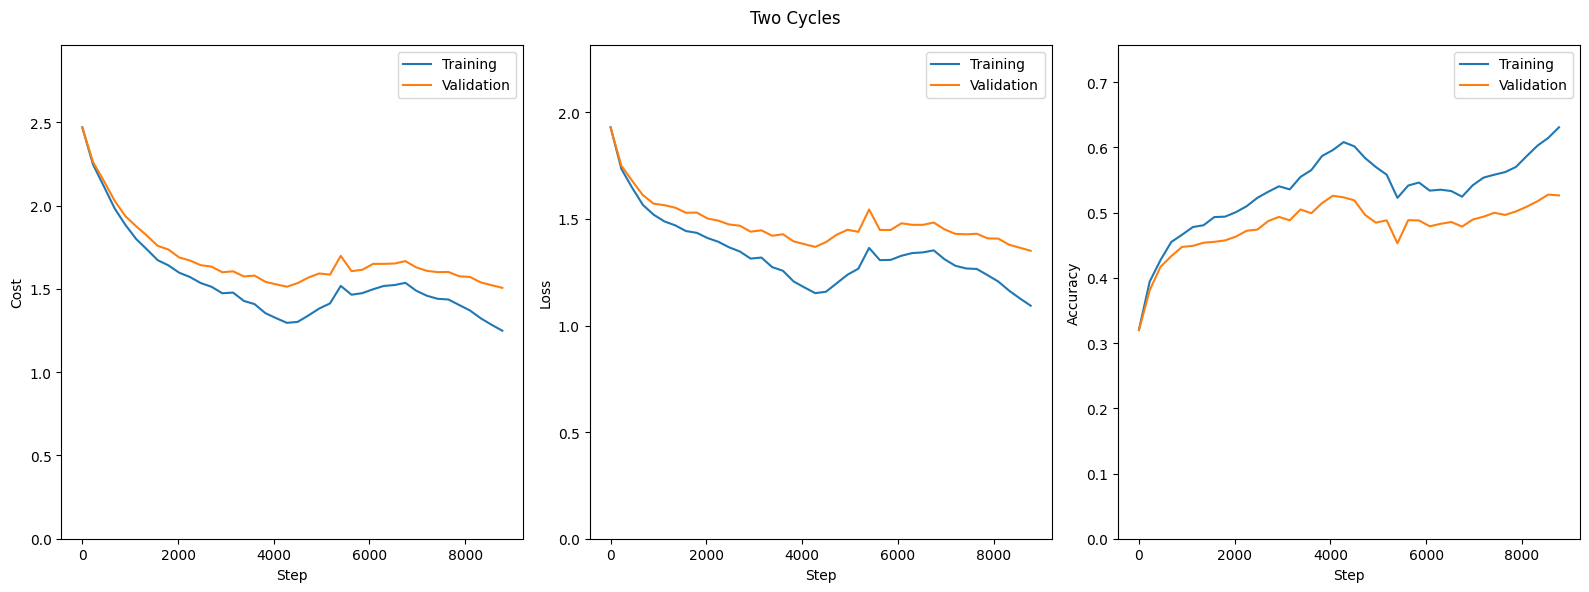

In [ ]:
vis.plotCyclicResults("Two Cycles", costs, loss, accs, stepsize)

In [ ]:
modelout.forward(test)
print("Test accuracy: ", modelout.computeAcc(test))

Test accuracy:  0.5171


# 9-Layer Training

In [ ]:
model = LinearKLayer(K, D, [50, 30, 20, 20, 10, 10, 10, 10], seed=65465168, batchnorm=True)
modelout, costs, loss, accs, lr = miniBatchGD(train, model, lmbd=lmbd, n_batch=n_batch, scheduler=lr_scheduler, n_epochs=n_epochs, val=val, pflip=0)

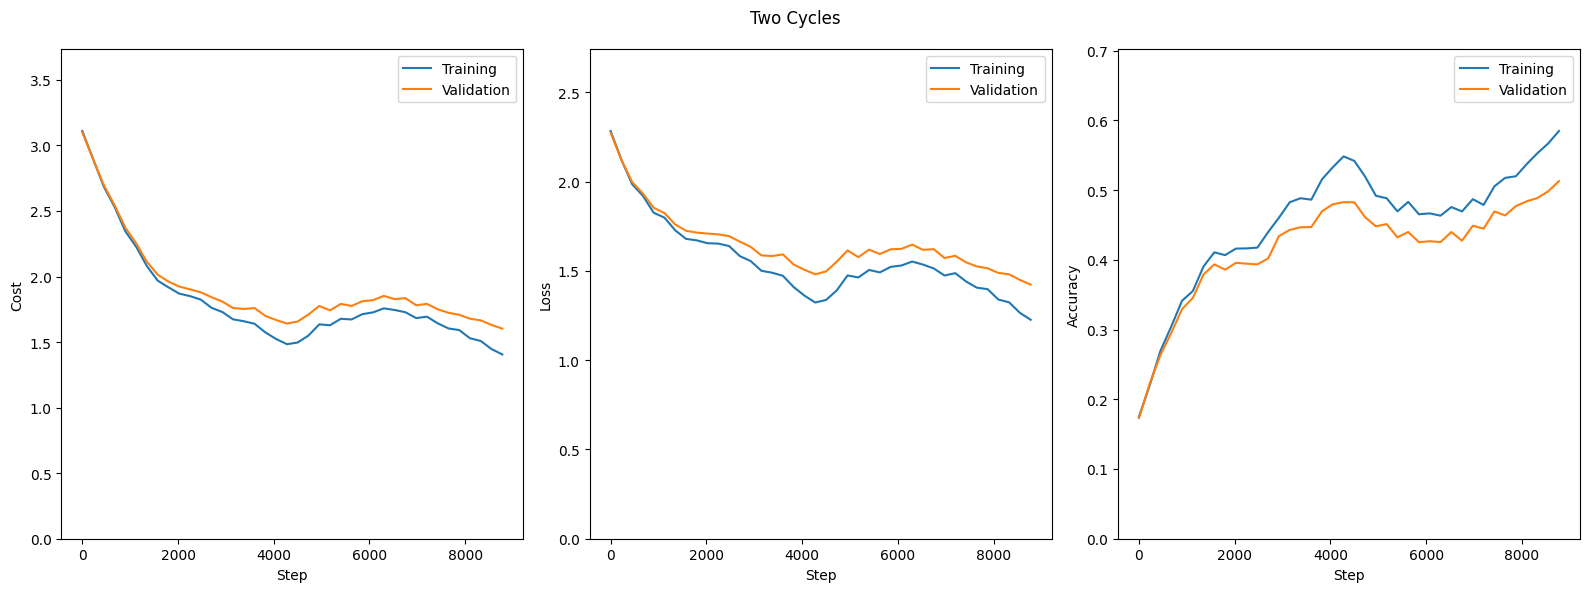

In [ ]:
vis.plotCyclicResults("Two Cycles", costs, loss, accs, stepsize)

In [ ]:
modelout.forward(test)
print("Test accuracy: ", modelout.computeAcc(test))

Test accuracy:  0.5015


In [ ]:
model = LinearKLayer(K, D, [50, 30, 20, 20, 10, 10, 10, 10], seed=65465168, batchnorm=False)
modelout, costs, loss, accs, lr = miniBatchGD(train, model, lmbd=lmbd, n_batch=n_batch, scheduler=lr_scheduler, n_epochs=n_epochs, val=val, pflip=0)

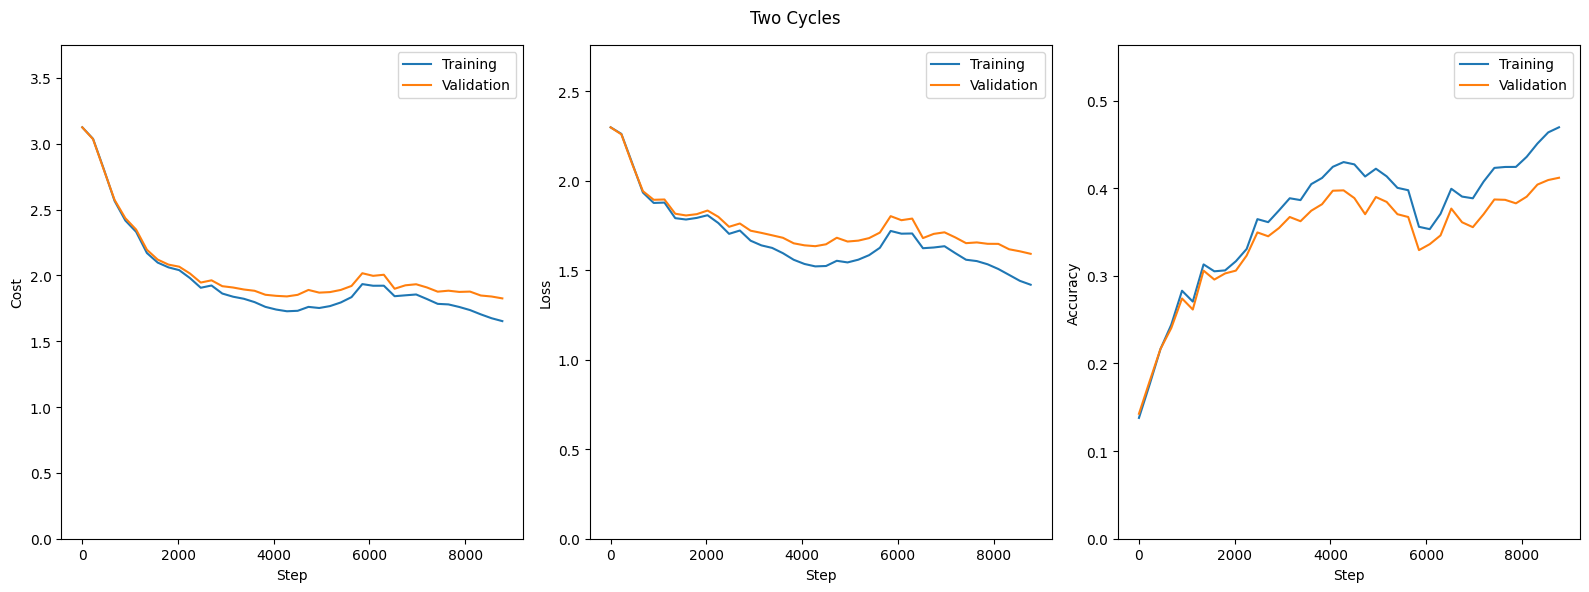

In [ ]:
vis.plotCyclicResults("Two Cycles", costs, loss, accs, stepsize)

In [ ]:
modelout.forward(test)
print("Test accuracy: ", modelout.computeAcc(test))

Test accuracy:  0.4141


# Hyperparameter Tuning

## Coarse Search

In [ ]:
# Load All Data

# Combine all training batches
alltrain = Data()
for _ in range(5):
    alltrain.concatData(f"data_batch_{_+1}")
alltrain.transform()

val = Data()
val.miniBatch(alltrain, [0, 5000])

train = Data()
train.miniBatch(alltrain, [5000,alltrain.data.shape[1]])

del alltrain

# Partition test batch into validation and test sets
test = Data("test_batch")

In [ ]:
eta_min, eta_max = 1e-5, 1e-1
n_batch = 100
stepsize = int(5*45000/n_batch)

lr_scheduler = ["cyclic",[eta_min, eta_max, stepsize]]

epoch_updates = train.data.shape[1]/n_batch
cycle_updates = 2 * stepsize
n_epochs_cycle = cycle_updates/epoch_updates

# 2 cycles worth of epochs
n_epochs = int(n_epochs_cycle * 2)

In [ ]:
n_search = 8
lmin, lmax = -5, -1
l = np.linspace(0, 1, n_search) * (lmax - lmin) + lmin
lambdas = np.power(10, l)

In [ ]:
val_accs = []

for i, lmbd in enumerate(lambdas):
    # If result exists, load it, otherwise train
    if os.path.isfile(f"results/lmbd_{i}.pkl"):
        with open(f"results/lmbd_{i}.pkl", "rb") as f:
            res = pickle.load(f)
    else:
        model = LinearKLayer(K, D, [50, 50], seed=65465168, batchnorm=True)
        modelout, costs, loss, accs, lr = miniBatchGD(train, model, lmbd=lmbd, n_batch=n_batch, scheduler=lr_scheduler, n_epochs=n_epochs, val=val, pflip=0)
        res = {
            "model": modelout,
            "costs": costs,
            "loss": loss,
            "accs": accs,
            "lr": lr
        }
        with open(f"results/lmbd_{i}.pkl", "wb") as f:
            pickle.dump(res, f)

    val_accs.append(res["accs"]["val"][-1])
    print(f"Lambda {i} : {lmbd}, Validation Accuracy: {res['accs']['val'][-1]}")

best_lambda = lambdas[np.argmax(val_accs)]
print(f"Best lambda: {best_lambda}")

Lambda 0 : 9.999999999999999e-06, Validation Accuracy: 0.5076
Lambda 1 : 3.727593720314938e-05, Validation Accuracy: 0.5028
Lambda 2 : 0.00013894954943731373, Validation Accuracy: 0.506
Lambda 3 : 0.0005179474679231212, Validation Accuracy: 0.5164
Lambda 4 : 0.0019306977288832496, Validation Accuracy: 0.521
Lambda 5 : 0.007196856730011514, Validation Accuracy: 0.529
Lambda 6 : 0.026826957952797246, Validation Accuracy: 0.5128
Lambda 7 : 0.09999999999999999, Validation Accuracy: 0.4708
Best lambda: 0.007196856730011514


In [ ]:
res = pickle.load(open(f"results/lmbd_{np.argmax(val_accs)}.pkl", "rb"))
bestmodel = res["model"]
bestmodel.forward(test, train=False)
print("Test accuracy: ", bestmodel.computeAcc(test))

Test accuracy:  0.5149


# Sensitivity to initialization

In [ ]:
# Load All Data

# Combine all training batches
alltrain = Data()
for _ in range(5):
    alltrain.concatData(f"data_batch_{_+1}")
alltrain.transform()

val = Data()
val.miniBatch(alltrain, [0, 5000])

train = Data()
train.miniBatch(alltrain, [5000,alltrain.data.shape[1]])

del alltrain

# Partition test batch into validation and test sets
test = Data("test_batch")

In [ ]:
eta_min, eta_max = 1e-5, 1e-1
n_batch = 100
# Factor 2 for speedup
stepsize = int(2*45000/n_batch)

lr_scheduler = ["cyclic",[eta_min, eta_max, stepsize]]

epoch_updates = train.data.shape[1]/n_batch
cycle_updates = 2 * stepsize
n_epochs_cycle = cycle_updates/epoch_updates

# 2 cycles worth of epochs
n_epochs = int(n_epochs_cycle * 2)

lmbd = best_lambda

In [ ]:
vis = Visualizer()

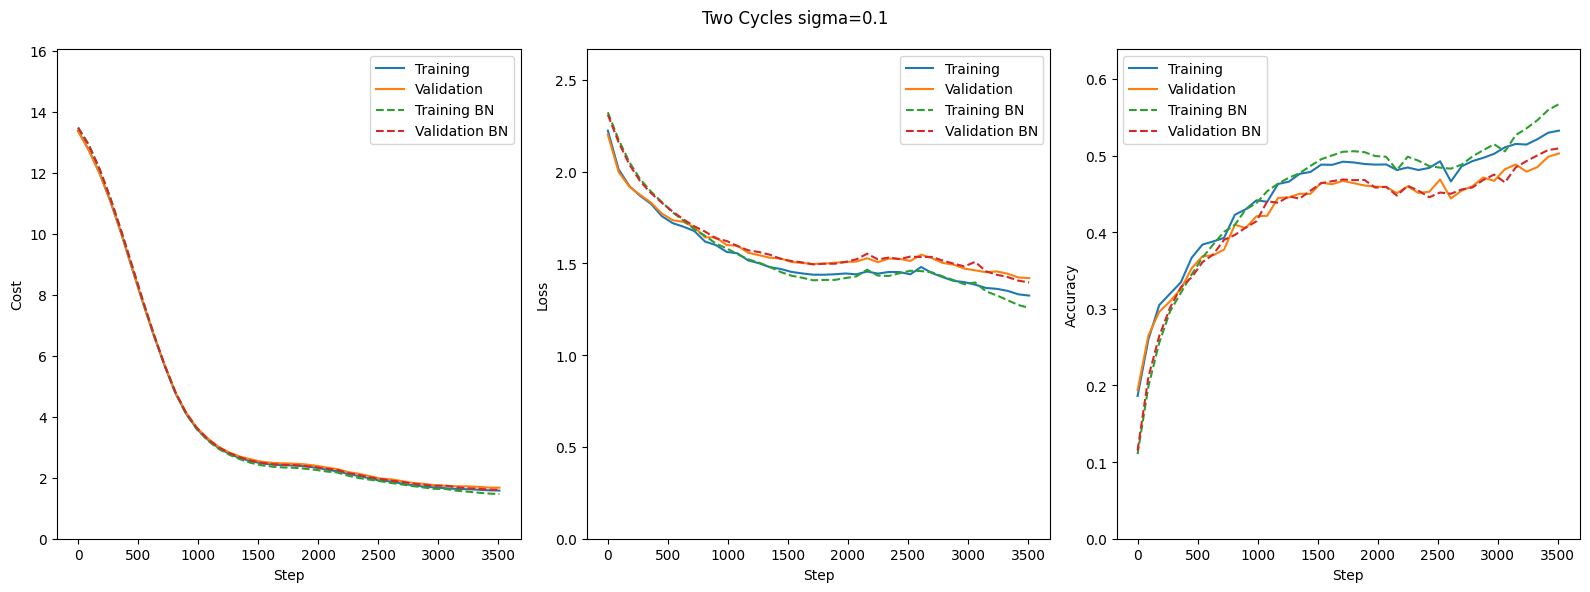

In [ ]:
sig = 1e-1
modelO = LinearKLayer(K, D, [50, 50], seed=65465168, batchnorm=False, sigma=sig)
modelout0, costs0, loss0, accs0, lr = miniBatchGD(train, modelO, lmbd=lmbd, n_batch=n_batch, scheduler=lr_scheduler, n_epochs=n_epochs, val=val, pflip=0)
modelBN = LinearKLayer(K, D, [50, 50], seed=65465168, batchnorm=True, sigma=sig)
modelout1, costs1, loss1, accs1, lr = miniBatchGD(train, modelBN, lmbd=lmbd, n_batch=n_batch, scheduler=lr_scheduler, n_epochs=n_epochs, val=val, pflip=0)

In [ ]:
vis.plotBnResults(f"Two Cycles sigma={sig}", [costs0, loss0, accs0], [costs1, loss1, accs1], stepsize)

In [ ]:
modelout0.forward(test)
print("Test accuracy no BN: ", modelout0.computeAcc(test))
modelout1.forward(test)
print("Test accuracy BN: ", modelout1.computeAcc(test))

Test accuracy no BN:  0.4972
Test accuracy BN:  0.4992


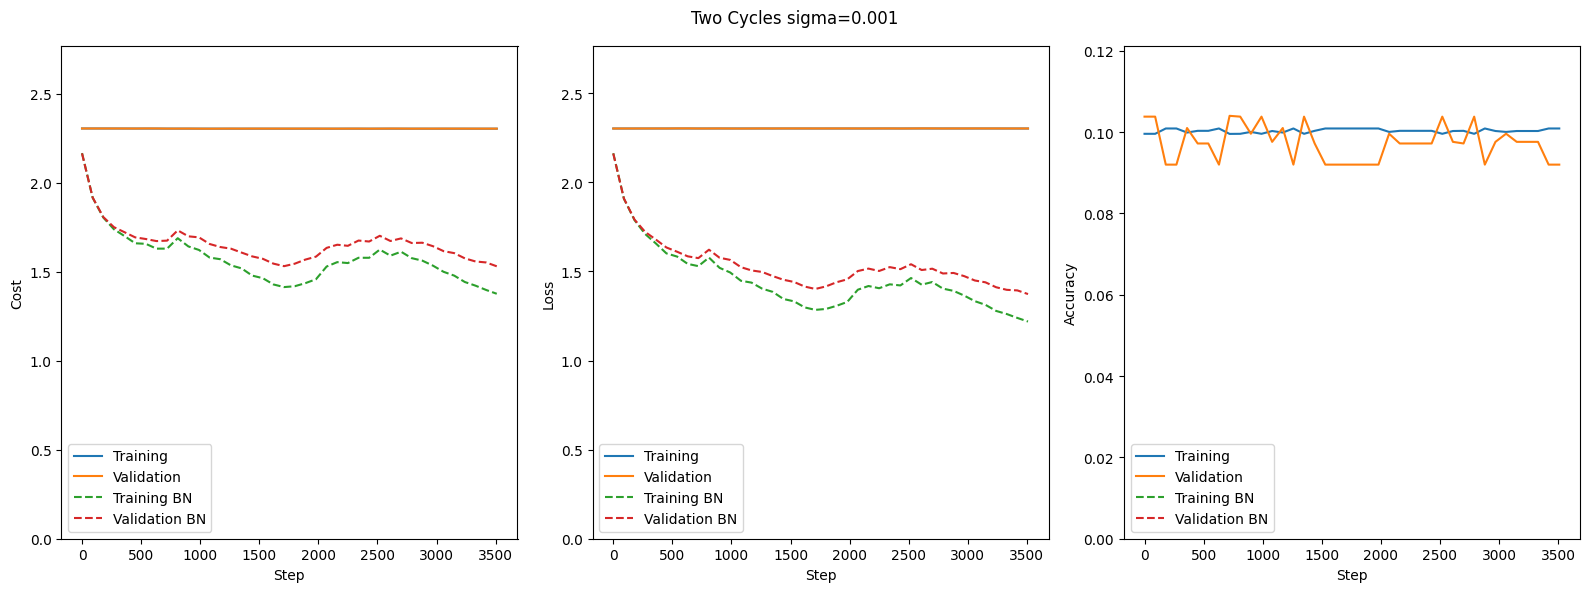

In [ ]:
sig = 1e-3
modelO = LinearKLayer(K, D, [50, 50], seed=65465168, batchnorm=False, sigma=sig)
modelout0, costs0, loss0, accs0, lr = miniBatchGD(train, modelO, lmbd=lmbd, n_batch=n_batch, scheduler=lr_scheduler, n_epochs=n_epochs, val=val, pflip=0)
modelBN = LinearKLayer(K, D, [50, 50], seed=65465168, batchnorm=True, sigma=sig)
modelout1, costs1, loss1, accs1, lr = miniBatchGD(train, modelBN, lmbd=lmbd, n_batch=n_batch, scheduler=lr_scheduler, n_epochs=n_epochs, val=val, pflip=0)

In [ ]:
vis.plotBnResults(f"Two Cycles sigma={sig}", [costs0, loss0, accs0], [costs1, loss1, accs1], stepsize)

In [ ]:
modelout0.forward(test)
print("Test accuracy no BN: ", modelout0.computeAcc(test))
modelout1.forward(test)
print("Test accuracy BN: ", modelout1.computeAcc(test))

Test accuracy no BN:  0.1
Test accuracy BN:  0.508


In [ ]:
sig = 1e-4
modelO = LinearKLayer(K, D, [50, 50], seed=65465168, batchnorm=False, sigma=sig)
modelout0, costs0, loss0, accs0, lr = miniBatchGD(train, modelO, lmbd=lmbd, n_batch=n_batch, scheduler=lr_scheduler, n_epochs=n_epochs, val=val, pflip=0)
modelBN = LinearKLayer(K, D, [50, 50], seed=65465168, batchnorm=True, sigma=sig)
modelout1, costs1, loss1, accs1, lr = miniBatchGD(train, modelBN, lmbd=lmbd, n_batch=n_batch, scheduler=lr_scheduler, n_epochs=n_epochs, val=val, pflip=0)

KeyboardInterrupt: 

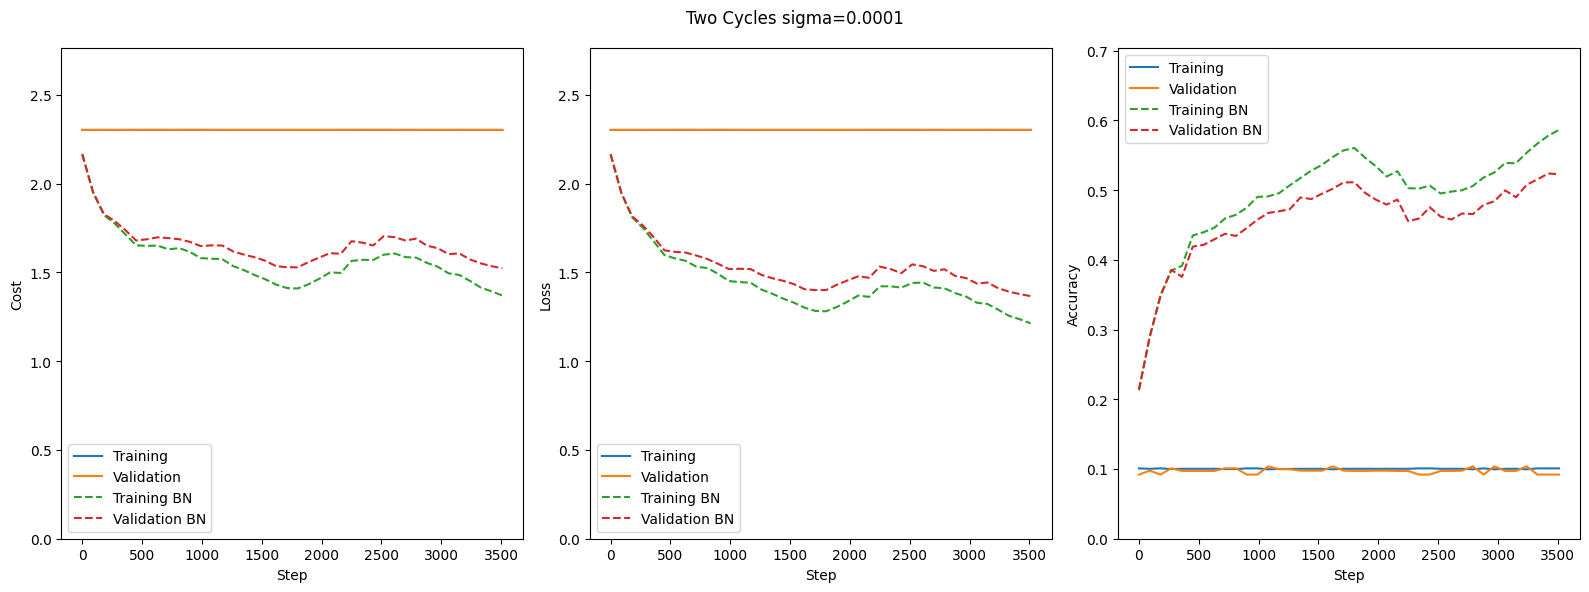

In [ ]:
vis.plotBnResults(f"Two Cycles sigma={sig}", [costs0, loss0, accs0], [costs1, loss1, accs1], stepsize)

In [ ]:
modelout0.forward(test)
print("Test accuracy no BN: ", modelout0.computeAcc(test))
modelout1.forward(test)
print("Test accuracy BN: ", modelout1.computeAcc(test))

Test accuracy no BN:  0.1
Test accuracy BN:  0.5157
